<h1> Introduction</h1>

With the rise of computational power and various machine learning techniques, many algorithms that
were previously infeasible are now computationally feasible. Instead of traditionally working from first
principles, there is now a much greater emphasis on leveraging data, unlocking the potential for
numerous remarkable achievements. One application of machine learning in dynamical systems that
shows promising results is SINDy (Sparse Identification of Non-linear Dynamics), first introduced in
2016 by Steven Brunton. SINDy is a data-driven algorithm used to model dynamical systems from
data. It collects snapshots of a dynamical system and optimises its model parameters or
regression coefficients such that the observed time derivatives match the estimated time derivatives
most closely. The model formed by the optimised model parameters can then be used to simulate,
forecast, and control the system.
<br>
<br>
While SINDy is a powerful data-driven tool, one of its biggest challenges is accurately identifying a
dynamical system model, especially given limited data availability. Similar to every machine learning
algorithm, it is a popular active research area to improve the efficiency of the algorithm so that it
can learn from data as effectively and efficiently as possible. Several extensions aimed at improving the noise robustness of the SINDy algorithm, such as applying ensemble methods, Bayesian
methods, or using the weak formulation of the loss function. Despite these advancements,
none of these frameworks focus on optimising the process of data extraction, which in a dynamical
system means controlling the dynamics to retrieve different snapshots. As with all machine learning
algorithms, high-quality data makes a huge difference in the final performance, underscoring a ripe
opportunity for further exploration in this field.
<br>
<br>
This research proposes an active learning framework for SINDy, Active-SINDy to tackle the mentioned
problem. The novelty of Active-SINDy lies in the application of active learning techniques with optimal experimental design, utilising optimal control methods to collect the most information-rich
data possible. This is motivated by the ideologies of optimality criteria in optimal experimental design, which aim to minimise the uncertainty of least squares estimation or increase the information
content of parameter estimates in regression-based problems. The concept of efficiently learning the
dynamical model is also closely related to optimal exploration in model-based reinforcement learning
(RL) settings, serving as a source of inspiration. Due to the close relationship between optimal
exploration and active learning in SINDy, some terms are used interchangeably in this research. By
implementing and experimenting with this active learning algorithm in a few known dynamical systems, statistically promising results are shown, indicating that it learns more efficiently than passive
learning in SINDy.

<H1> Libraries </H1>

A few third-party libraries are involved. CasADi is utilized for the validation of the reference tracking error of the estimated SINDy model. Although not used in this introductory notebook, the multiprocessing and concurrent libraries are intended for the parallelization of each pair of random and optimal explorations to enable faster computation when run on a high-performance computing system.

In [1]:
# Third Party Libraries Involved
import numpy as np
import time
import pysindy as ps
import torch
import casadi as ca

import matplotlib.pyplot as plt
import copy
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor, wait, ALL_COMPLETED

In [2]:
# Self Written Libraries
from Environment import HIVEnvironment, ModelEvaluate
from HyperParametersFind import ControlInput
from Kernel import HIVKernel
from Exploration import RandomExploration, TraceExploration

<h1> System Variables </h1>

In both the HIV dynamical system and the F8 pitch system, the system can be written in the form $\dot{x} = Ax$. The system matrix A characterizes the behavior of the dynamical system. It is therefore important to specify the non-linear terms involved in the system during this process.
<br>
<br>
The kernel is a function that takes in the states as input and transforms into all the non-linear terms involved.

In [3]:
# System Variables (For HIV Dynamics, specifying the system matrix A)
lambda1_sys = 1
d_sys = 0.1
beta_sys = 1
a_sys = 0.2
p1_sys = 1
p2_sys = 1
c1_sys = 0.03
c2_sys = 0.06
b1_sys = 0.1
b2_sys = 0.01
q_sys = 0.5
h_sys = 0.1 
eta_sys = 0.9799
states_init = torch.tensor([10, 0.1, 0.1, 0.1, 0.1])
A_true = torch.tensor([[lambda1_sys, -d_sys, 0.0, 0.0, 0.0, 0.0, 0.0, -beta_sys, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, beta_sys*eta_sys],
                       [0.0, 0.0, -a_sys, 0.0, 0.0, 0.0, 0.0, beta_sys, 0.0, -p1_sys, -p2_sys, 0.0, 0.0, 0.0, -beta_sys*eta_sys],
                       [0.0, 0.0, 0.0, -b2_sys, 0.0, 0.0, 0.0, 0.0, -c2_sys*q_sys, 0.0, 0.0, c2_sys, 0.0, 0.0, 0.0],
                       [0.0, 0.0, 0.0, 0.0, -b1_sys, 0.0, 0.0, 0.0, 0.0, c1_sys, 0.0, 0.0, 0.0, 0.0, 0.0],
                       [0.0, 0.0, 0.0, 0.0, 0.0, -h_sys, 0.0, 0.0, c2_sys*q_sys, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])


noise_cov = 1e-2
dimu = 1

kernel = HIVKernel()

<h1>Experimemt Details</h1>

This configuration outlines the parameters used for running trajectory simulations with various optimization and exploration strategies. The number of trajectories considered in each epoch is controlled by `N_explore`, which is set to 1 for introduction, meaning a single trajectory is explored per epoch. The simulation runs for a total of `N_horizon` seconds—10 seconds in this case—and a fraction of this horizon, defined by `sim_frac` (set to 0.01), is used for calculating the associated optimality cost of the trajectory.

The simulation is repeated `experiment_repeat` times for statistical significance and to evaluate different runs. `n_processes` is set to 5 for 5 pairs of random and optimal explorations, and `n_processes_hyperparameters` is set to 25 for 25 parallel trajectories with 25 different hyperparameters for the forcing signal. Together, 5 * 25 = 125 processes would be required. The input signal type used to excite the system can vary, with the current setup using a "ChirpLinear" signal. Other signal types, such as "SinWave", "SchroederSweep", or "PRBS," could also be used. The signal amplitude is set to 1.

The experiment's objective, denoted by `ExpObj`, is "A_Optimal," which refers to one of several possible optimization criteria, such as "D_Optimal," "E_Optimal," or "MV-Optimal." A random seed (`random_seed = 0`) ensures the reproducibility of the results. Various evaluation metrics are available to assess the model's performance, with the current setup using a range of metrics, including "default," "normalized," "mape," "mae," "mse," and "lq_cost." These metrics help evaluate model accuracy and fit across different dimensions, such as mean absolute error (MAE), mean squared error (MSE), and normalized errors.

In [4]:
# Defining Experiment Details

# N_explore = 25 # Number of Trajectories Considered in Each Step
# N_horizon = 10 # Seconds to simulate
# sim_frac = 1.0
# epochs = [2,1,1,1,1,1,1,1,1]
N_explore = 1 # Number of Trajectories Considered in Each Step
N_horizon = 10 # Seconds to simulate
sim_frac = 0.01 # Fraction of the horizon used for calculating the cost
epochs = [2,1,1]

experiment_repeat = 5
n_processes, n_processes_hyperparameters = 5, 25
signal_type = "ChirpLinear" # "SinWave" or "Sin2Wave" or "ChirpLinear" or "SchroederSweep" or "PRBS"
amplitude = 1
ExpObj = "A_Optimal" # "A_Optimal" or "D_Optimal" or "E_Optimal" or "MV-Optimal" or "G_Optimal"
random_seed = 0
metrics = ["default","normalized","mape","mae","mse","lq_cost"] # "default" or "normalized" or "mape" or "mae" or "mse" or "r2" or "lq_cost"

<h1> Prediction Parameters </h1>

The `prediction_parameters` dictionary sets the initial conditions and settings for evaluating predictions in a simulation. It specifies the initial state of the system with `states_init` set to `[0.3, 5, 0.0, 0.2, 1.1]`, which represents the starting values of the system's state variables. The simulation runs for a duration of `sim_time`, which is set to 10 seconds. The `signal_type` used for input stimulation during the simulation is "SchroederSweep," and `hyperparams` is an array `[30, 22]` that represents the specific hyperparameters for the forcing signal "SchroederSweep".

For reference tracking evaluation, the `controller_parameters` dictionary defines the setup for controlling and optimizing the system. It includes symbolic representations of state variables (`a`, `b`, `c`, `d`, `e`) and control variables (`u`) using the CasADi symbolic framework. The `states` key combines these variables into a single vector, while `controls` defines the control inputs. The `states_mapped` key specifies the non-linear kernel of the system in a symbolic format with the CasADi framework.

The optimization problem is defined with `N` set to 10, indicating the number of horizon length. The `Q` and `R` matrices are used to weight the state and control costs in the cost function, respectively. The state and control variable bounds are specified by `x_lb`, `x_ub`, `u_lb`, and `u_ub`, setting the limits for the state and control variables. Initial state values are provided by `states_init`, with a target state defined in `states_target`. The time step for the actual environment and trajectory forecasting is set by `dt` and `dt_simulate`, both equal to 0.02 seconds, and the total simulation time is set to 35 seconds (5*7).

In [5]:
# Prediction Evaulation
prediction_parameters = {
    'states_init' : np.array([0.3, 5, 0.0, 0.2, 1.1]),
    'sim_time' : 10,
    'signal_type' : 'SchroederSweep',
    'hyperparams' : np.array([30, 22])
}

# Reference Tracking Evaulation
a, b, c, d, e = ca.SX.sym('a'), ca.SX.sym('b'), ca.SX.sym('c'), ca.SX.sym('d'), ca.SX.sym('e') # States variables
u = ca.SX.sym('u') # Control variables
controller_parameters = {
    'states': ca.vertcat(a, b, c, d, e),
    'controls': ca.vertcat(u),
    'states_mapped': [1, a, b, c, d, e, u, a*b, b*c, b*d, b*e, a*b*c, a*b*d, a*b*e, a*b*u],
    'N' : 10,
    'Q': ca.diagcat(2e1, 0e1, 10e1, 0e1, 0e1),
    'R': ca.diagcat(5),
    'x_lb': [-10000, -10000, -10000, -10000, -10000],
    'x_ub': [10000, 10000, 10000, 10000, 10000],
    # 'u_lb': [0],
    # 'u_ub': [1],
    'u_lb': [-10000],
    'u_ub': [10000],
    # 'states_init': [0.3, 5, 0.0, 0.2, 1.1],
    'states_init': [10, 0.1, 0.1, 0.1, 0.1],
    'states_target': [0.291262135922330, 3.33333333333333, 0, 0.0912621359223301, 0],
    # 'states_target': [8.22546496e0, 2.15736745e-02, 15.4000897e0, 0, 8.02546496e0],
    'dt' : 2e-2,
    'dt_simulate' : 2e-2,
    'sim_time' : 5*7
}

<h2> Resetting all the environments (both true and estimated) </h2>

This is simply to ensure that the environments used in each random and optimal exploration are not corrupted and do not affect the rest of the experiment runs. The environments returned are newly created environments.

In [6]:
def reset_explore(kernel):
    true_instance = HIVEnvironment(A=A_true,dimu=dimu,noise_cov=noise_cov,states_init=states_init,kernel=kernel,dt=0.01)
    est_instance = copy.deepcopy(true_instance)
    est_instance.reset_dynamics()
    forcing = ControlInput(signal_type=prediction_parameters['signal_type'])
    evaluate = ModelEvaluate(true_instance, forcing, metrics, prediction_parameters=prediction_parameters, controller_parameters=controller_parameters)
    return true_instance, est_instance, evaluate

<h1> Main Loop </h1>


This section performs a series of experiments to evaluate different exploration strategies for system identification. The process starts by initializing empty lists to store historical data from multiple runs: `X_history_all`, `U_history_all`, `Hyperparams_history_all`, and `error_history_all`. The random seed is set to ensure reproducibility of results.

The script then iterates through a specified number of experiments (`experiment_repeat`). For each experiment, it first conducts a **Random Exploration**. During this phase, the environment is reset, and a random exploration policy (`explore_policy_rand`) is instantiated using the `RandomExploration` class. This policy performs system identification by exploring random trajectories based on the provided kernel, signal type, and other parameters. The historical data for states (`X_history`), controls (`U_history`), hyperparameters (`Hyperparams_history`), and errors (`error_history`) from this exploration are collected and appended to the respective lists.

Following the random exploration, it proceeds with an **Optimal Exploration**. Similar to the random exploration, the environment is reset, but this time an optimal exploration policy (`explore_policy_trace`) is used. Opitmal exploration performs system identification by exploring optimal trajectories based on predefined hyperparameters and evaluation metrics with a starting point generated from random exploration. The results from this exploration, including state, control, hyperparameter, and error histories, are also collected and appended to the lists.

Overall, this section evaluates and stores the outcomes of both random and optimal exploration strategies across multiple experiments to compare their effectiveness in system identification.

In [8]:
X_history_all, U_history_all, Hyperparams_history_all, error_history_all = [],[],[],[]
np.random.seed(random_seed)

for i in range(experiment_repeat):
    # Random Exploration
    print("Random Exploration : Introduction : ", i)
    true_instance, est_instance, evaluate = reset_explore(kernel=kernel)
    explore_policy_rand = RandomExploration(N_explore, N_horizon, signal_type, amplitude, evaluate, kernel, metrics=metrics)
    est_instance, cov, U_history, X_history, Hyperparams_history, error_history = explore_policy_rand.system_id(
        true_instance, est_instance, epochs, closed_form=False, verbose=1)

    X_history_all.append(X_history)
    U_history_all.append(U_history)
    Hyperparams_history_all.append(Hyperparams_history)
    error_history_all.append(error_history)

    # Optimal Exploration
    print("Optimal Exploration : Introduction : ", i)
    true_instance, est_instance, evaluate = reset_explore(kernel=kernel)
    explore_policy_trace = TraceExploration(N_explore, N_horizon, n_processes_hyperparameters, signal_type, amplitude, evaluate, kernel, sim_frac=sim_frac, ExpObj=ExpObj, metrics=metrics)
    est_instance, cov, U_history, X_history, Hyperparams_history, error_history = explore_policy_trace.system_id(
        true_instance, est_instance, epochs, hyperparams_control=Hyperparams_history, closed_form=False, verbose=1)

    X_history_all.append(X_history)
    U_history_all.append(U_history)
    Hyperparams_history_all.append(Hyperparams_history)
    error_history_all.append(error_history)

Random Exploration : Introduction :  0
Epoch  0  :  loss : [tensor(0.0544), tensor(0.0558), 0.027147234133360353, 0.031561742583678824, 0.00416105099040297, 6.282289246406173]
Epoch  1  :  loss : [tensor(0.0263), tensor(0.0270), 0.017854899064993063, 0.023156870035762625, 0.002401176996148783, 0.016020488829661894]
Epoch  2  :  loss : [tensor(0.0326), tensor(0.0330), 0.035246826772015474, 0.029550075226408946, 0.0033967959085764465, 0.0015958580953712447]
Optimal Exploration : Introduction :  0
Epoch  0  :  loss : [tensor(0.0544), tensor(0.0558), 0.027147234133360353, 0.031561742583678824, 0.00416105099040297, 6.282289246406173]
Hyperparameters Chosen :  [[0.96438951 4.45097367]]
Epoch  1  :  loss : [tensor(0.0473), tensor(0.0480), 0.02506568862183086, 0.02535002201518165, 0.0025647745295229105, 0.016016373859108837]
Hyperparameters Chosen :  [[0.79589054 5.76005428]]
Epoch  2  :  loss : [tensor(0.0356), tensor(0.0366), 0.0378442635059142, 0.0323625208171798, 0.003836797724192498, 0.00

c:\Users\Cyrus\OneDrive - Imperial College London\Documents\GitHub\Active-Learning-SINDy\Kernel.py:33: RuntimeWarning: overflow encountered in scalar multiply
  ab * x[2], ab * x[3], ab * x[4],
c:\Users\Cyrus\OneDrive - Imperial College London\Documents\GitHub\Active-Learning-SINDy\Environment.py:89: RuntimeWarning: invalid value encountered in matmul
  x_dot = np.matmul(np.array(self.A),phi)
c:\Users\Cyrus\anaconda3\envs\pytorch\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Epoch  0  :  loss : [tensor(0.8834), tensor(60.2479), nan, nan, nan, 6.282167434163202]
Epoch  1  :  loss : [tensor(0.0409), tensor(0.0421), 0.024837191650082933, 0.028861880688455833, 0.003574605340023067, 0.016000068693491895]
Epoch  2  :  loss : [tensor(0.0109), tensor(0.0109), 0.009830113344809136, 0.009706685429520506, 0.0004320554914346547, 0.0015999106741992743]
Optimal Exploration : Introduction :  3


c:\Users\Cyrus\OneDrive - Imperial College London\Documents\GitHub\Active-Learning-SINDy\Kernel.py:33: RuntimeWarning: overflow encountered in scalar multiply
  ab * x[2], ab * x[3], ab * x[4],
c:\Users\Cyrus\OneDrive - Imperial College London\Documents\GitHub\Active-Learning-SINDy\Environment.py:89: RuntimeWarning: invalid value encountered in matmul
  x_dot = np.matmul(np.array(self.A),phi)
c:\Users\Cyrus\anaconda3\envs\pytorch\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Epoch  0  :  loss : [tensor(0.8834), tensor(60.2479), nan, nan, nan, 6.282167434163202]
Hyperparameters Chosen :  [[0.67343138 7.03574083]]
Epoch  1  :  loss : [tensor(0.0603), tensor(0.0632), 0.025796345912159215, 0.02888275120837937, 0.0031729096439238867, 0.015986170419988743]
Hyperparameters Chosen :  [[0.22617491 2.16033668]]
Epoch  2  :  loss : [tensor(0.0774), tensor(0.0804), 0.030743471495647733, 0.0370107499020456, 0.005976713958656363, 0.001618813149997083]
Random Exploration : Introduction :  4
Epoch  0  :  loss : [tensor(0.0656), tensor(0.0670), 0.026407229166933978, 0.03141205565641696, 0.004289058656303456, 6.282270794448861]
Epoch  1  :  loss : [tensor(0.0230), tensor(0.0230), 0.026636250972858093, 0.028491337737561222, 0.003646618036512767, 0.01601922638156004]
Epoch  2  :  loss : [tensor(0.0253), tensor(0.0254), 0.028235156535562668, 0.029091661062074774, 0.0037908260752118777, 0.0015990467827732165]
Optimal Exploration : Introduction :  4
Epoch  0  :  loss : [tensor(0

<h1> Data Analysis </h1>

For the purpose of this introduction, only the percentile plot is shown. In a regular run on an HPC system, the DataAnalysis.py script is used instead. This script should be run separately (please ensure the folder path is correct so that PyTorch can load the variables stored in the SimulationData folder). The DataAnalysis.py script generates a comprehensive plot for analyzing simulation data.

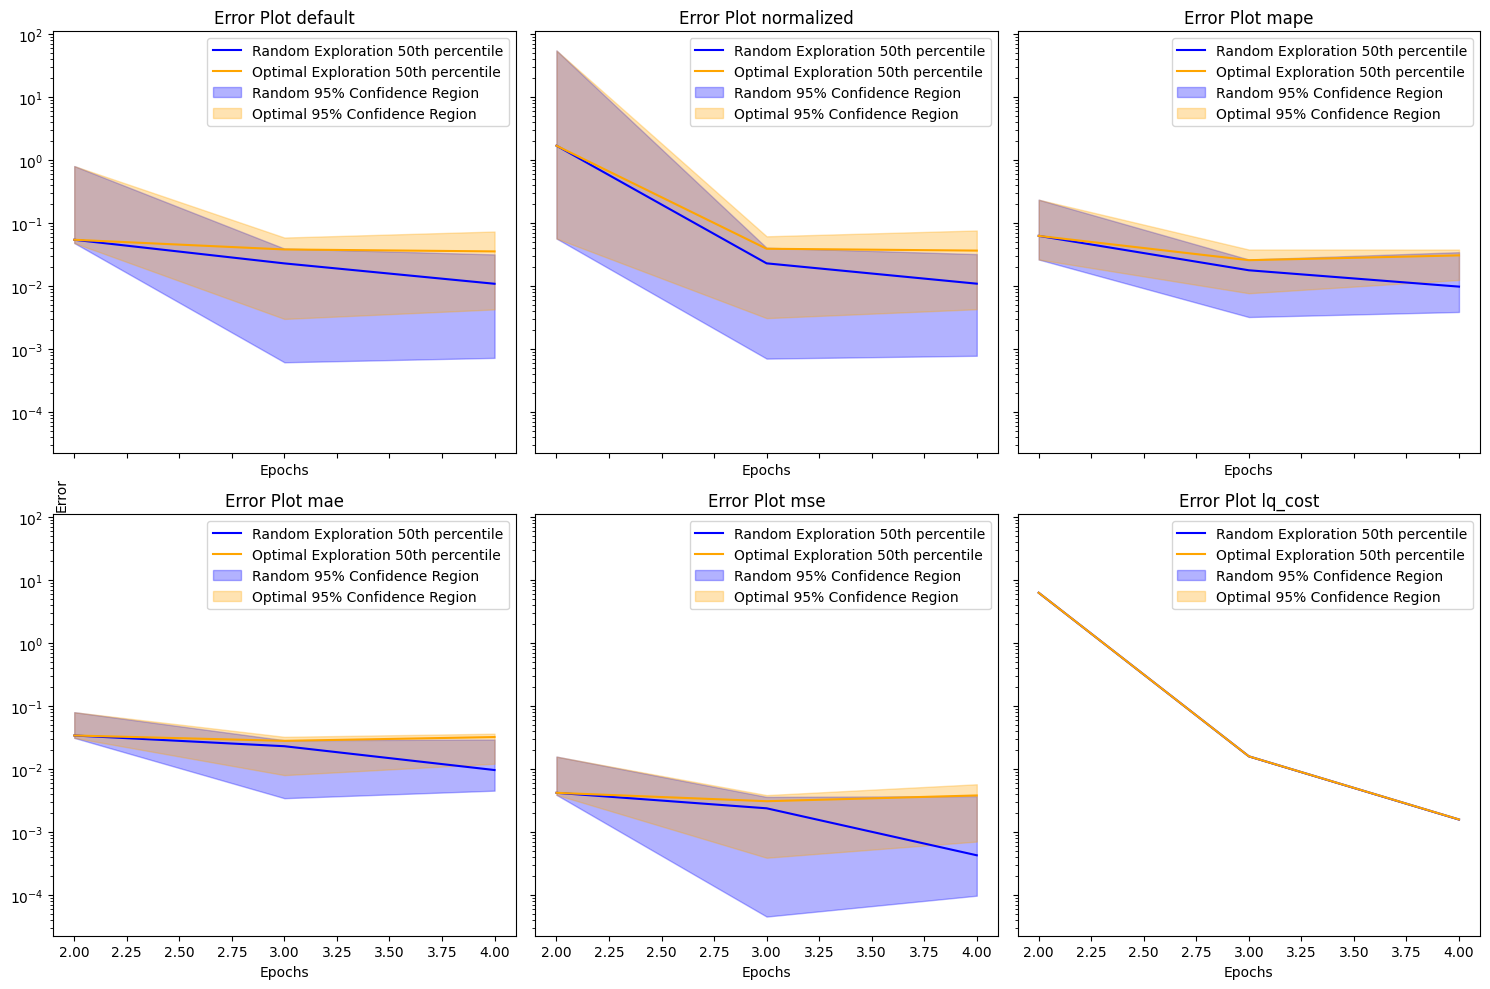

Percentile plots successfully plotted


In [9]:
# Percentile plots
import seaborn as sns
import pandas as pd

n_experiments = int(len(error_history_all)/2)
n_epochs = np.sum(np.array(epochs))
n_metrics = len(metrics)
num_columns = (n_metrics + 1) // 2

# Create subplots with 2 rows and num_columns columns
fig, axs = plt.subplots(2, num_columns, figsize=(num_columns * 5, 10), sharex=True, sharey=True)

# Flatten the 2D axs array for easy iteration
axs = axs.flatten()

xlabel = torch.cumsum(torch.tensor(epochs).clone().detach(), 0).clone().detach()

for m in range(n_metrics):
    # Collect all error values at each epoch
    errors_random, errors_optimal = [], []
    for i in range(len(error_history_all)):
        error_history = torch.tensor(error_history_all[i])[:, m]
        if np.mod(i, 2) == 0:
            errors_random.append(np.array(error_history))
        else:
            errors_optimal.append(np.array(error_history))

    errors_random = np.array(errors_random)
    errors_optimal = np.array(errors_optimal)

    confidence_level = 95
    lower_percentile = (100 - confidence_level) / 2
    upper_percentile = 100 - lower_percentile

    errors_random_low = np.nanpercentile(errors_random, lower_percentile, axis=0)
    errors_random_50 = np.nanpercentile(errors_random, 50, axis=0)
    errors_random_upper = np.nanpercentile(errors_random, upper_percentile, axis=0)

    errors_optimal_low = np.nanpercentile(errors_optimal, lower_percentile, axis=0)
    errors_optimal_50 = np.nanpercentile(errors_optimal, 50, axis=0)
    errors_optimal_upper = np.nanpercentile(errors_optimal, upper_percentile, axis=0)

    # Plot in the corresponding subplot axis
    ax = axs[m]  # Access the current subplot

    ax.plot(xlabel, errors_random_50, color='blue', label='Random Exploration 50th percentile')
    ax.plot(xlabel, errors_optimal_50, color='orange', label='Optimal Exploration 50th percentile')

    ax.fill_between(xlabel, errors_random_low, errors_random_upper, color='blue', alpha=0.3, label="Random 95% Confidence Region")
    ax.fill_between(xlabel, errors_optimal_low, errors_optimal_upper, color='orange', alpha=0.3, label="Optimal 95% Confidence Region")

    ax.set_yscale('log')
    ax.set_xlabel("Epochs")
    ax.set_title(f"Error Plot {metrics[m]}")
    ax.legend()

# Hide any extra subplots if n_metrics is odd
if n_metrics % 2 != 0:
    axs[-1].axis('off')

# Set shared y-axis label for all subplots
fig.text(0.04, 0.5, 'Error', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

print("Percentile plots successfully plotted")